# Projet Spam/Ham 

## Importation des librairies 

In [87]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import FunctionTransformer, Pipeline

from sklearn import svm
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, recall_score, f1_score
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
import pandas as pd
import string
import numpy as np
from sklearn.model_selection import GridSearchCV

In [88]:
df = pd.read_csv("SMSSpamCollection", header=None, sep='\t', names=['cat', 'msg'])

## Preproccessing 

### Functions utilities 

In [89]:
def punctuation_ratio(text_series):
    punctuations = string.punctuation
    return text_series.apply(lambda text: sum(1 for char in text if char in punctuations) / len(text) if len(text) > 0 else 0)

def uppercase_ratio(text_series):
    return text_series.apply(lambda text: sum(1 for c in text if c.isupper()) / len(text) if len(text) > 0 else 0)

def digits_ratio(text_series):
    return text_series.apply(lambda text: sum(char.isdigit() for char in text) / len(text) if len(text) > 0 else 0)

#def len_message(text_series):
    #return text_series.apply(len)

In [90]:
def create_column_df(X):

    df=pd.DataFrame(data=X,columns=["msg"])
    df['punctuation_ratio'] = punctuation_ratio(df['msg'])
    df['uppercase_ratio'] = uppercase_ratio(df['msg'])
    df['digit_ratio'] =  digit_ratio(df['msg'])
    #df['msg_length'] = len_message(df['msg'])
    return df

### FunctionTransformer

In [91]:
ajout_column_preproccessing = FunctionTransformer(create_column_df, validate=False)

### vectorizer

In [93]:
text_vectorizer = TfidfVectorizer(min_df=3, max_df=0.9)

vectorizer = ColumnTransformer(
    transformers=[
        ('text', text_vectorizer, 'msg'),
    ]
)

### Pipeline Preproccessing

In [94]:
preprocessor=Pipeline(steps=[
    ('ajout', ajout_column_preproccessing),
    ('vectorizer', vectorizer),
    ('dim_reduction', TruncatedSVD(n_components=150, random_state=42))
    

])

## model

### Pipeline Model

### Classificateur SVM 

In [96]:
# Pipeline complète
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor), 
    ('classifier', svm.SVC())
])


X = df['msg']
y = df['cat'].apply(lambda x: 1 if x == 'spam' else 0)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Grid_Search

In [97]:
param_grid = {
    'classifier__C': [0.1, 1, 10, 15, 20, 25],
    'classifier__kernel': ['rbf'],
    'classifier__gamma': ['scale', 'auto'],
    'classifier__class_weight': ['balanced'],  
    'classifier__break_ties' :[True, False]
}

In [99]:
grid_search = GridSearchCV(model_pipeline, param_grid, scoring='f1', cv = 5, n_jobs =-1, verbose = 1)

#grid_search.fit(X_train, y_train)

#y_pred = grid_search.predict(X_test)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        Pipeline(steps=[('ajout',
                                                         FunctionTransformer(func=<function create_column_df at 0x7f06e2cc37e0>)),
                                                        ('vectorizer',
                                                         ColumnTransformer(transformers=[('text',
                                                                                          TfidfVectorizer(max_df=0.9,
                                                                                                          min_df=3),
                                                                                          'msg')])),
                                                        ('dim_reduction',
                                                         TruncatedSVD(n_components=150,
                                                                      random_state=42))])),
                                       ('classifier', SVC())]),
             n_jobs=-1,
             param_grid={'classifier__C': [0.1, 1, 10, 15, 20, 25],
                         'classifier__break_ties': [True, False],
                         'classifier__class_weight': ['balanced'],
                         'classifier__gamma': ['scale', 'auto'],
                         'classifier__kernel': ['rbf']},
             scoring='f1', verbose=1)

### Parameter Optimization

In [101]:
#best_model = grid_search.best_estimator_
#print("Meilleur modèle:", best_model)
#y_pred = best_model.predict(X_test)

Meilleur modèle: Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('ajout',
                                  FunctionTransformer(func=<function create_column_df at 0x7f06e2cc37e0>)),
                                 ('vectorizer',
                                  ColumnTransformer(transformers=[('text',
                                                                   TfidfVectorizer(max_df=0.9,
                                                                                   min_df=3),
                                                                   'msg')])),
                                 ('dim_reduction',
                                  TruncatedSVD(n_components=150,
                                               random_state=42))])),
                ('classifier',
                 SVC(C=10, break_ties=True, class_weight='balanced'))])


In [102]:
model_pipeline.fit(X_train, y_train)
y_pred = model_pipeline.predict(X_test)

## model evaluation

In [103]:
#accuracy
print("accuracy: ", accuracy_score(y_test, y_pred))

Accuracy:  0.9904306220095693


In [104]:
# recall 
print('recall: ', recall_score(y_test, y_pred))

recall:  0.9553571428571429


In [105]:
# f1-score
print('f1-score ', f1_score(y_test, y_pred))

f1-score  0.963963963963964


Rapport de classification :
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1448
           1       0.97      0.96      0.96       224

    accuracy                           0.99      1672
   macro avg       0.98      0.98      0.98      1672
weighted avg       0.99      0.99      0.99      1672



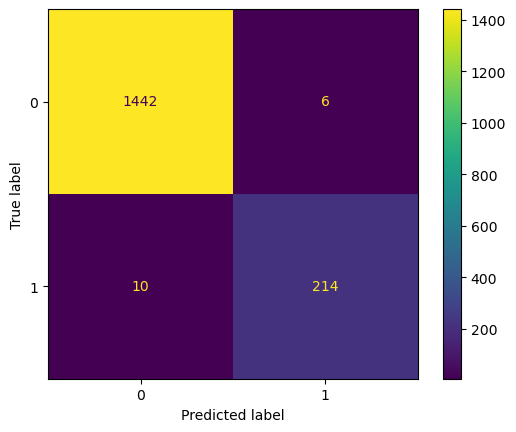

In [106]:
print("Rapport de classification :")
print(classification_report(y_test, y_pred))
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot()
plt.show()